In [1]:
#labeling
import pandas as pd

df = pd.read_csv("discharge-hfdxonly-first-sampleS0_labeled.csv")

#print(df.head())

texts = df["text"]

#print(texts[99])
#matrix for label
# labels=[1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
# 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
# 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
# 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
# 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
# 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
# 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
# 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
# 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
# 1, 1, 1, 1, 0, 0, 1, 1, 1, 1]
# df["is HF? (1,0: 1 for yes, 0 for no)"] = labels

# df.to_csv("discharge-hfdxonly-first-sampleS0_labeled.csv", index=False)
# not considering history

# HF with LLM

In [2]:
import sys
def check_package(package_name):
    """
    Check if a package is installed in Python.

    Args:
        package_name: Name of the package to check

    Returns:
        bool: True if package is installed, False otherwise
    """
    try:
        import importlib.metadata
        version = importlib.metadata.version(package_name)
        print(f"✓ {package_name} is installed (version: {version})")
        return True
    except importlib.metadata.PackageNotFoundError:
        print(f"✗ {package_name} is not installed")
        return False

def check_python_version():
    """Check Python version"""
    version = sys.version_info
    print(f"✓ Python {version.major}.{version.minor}.{version.micro}")
    if version.major < 3 or (version.major == 3 and version.minor < 7):
        print("  ⚠️  Warning: Python 3.7+ recommended")
    return True

def check_package_main():
    checks = []

    # Check Python
    checks.append(check_python_version())
    print()

    # Check core packages
    print("Checking required packages:")
    checks.append(check_package("google-genai"))
    checks.append(check_package("langgraph"))
    checks.append(check_package("langchain"))
    checks.append(check_package("langchain-google-genai"))
    checks.append(check_package("python-dotenv"))

    # checks.append(check_pytorch())
    # checks.append(check_package("torchvision"))
    # checks.append(check_package("numpy"))
    # checks.append(check_package("matplotlib"))

    print("\n" + "="*60)

    if all(checks):
        print("✅ All dependencies installed!")
    else:
        print("❌ Some dependencies are missing")
        print("\nTo install missing packages:")
        print("  !pip install -q -U google-genai langgraph langchain python-dotenv langchain-google-genai ")
        # !pip install -q -U google-genai langgraph langchain python-dotenv langchain-google-genai
    print("="*60)

In [22]:
#!pip install -q -U google-genai langgraph langchain python-dotenv langchain-google-genai
!pip install -U google-generativeai langchain langchain-core langchain-google-genai


  Using cached google_ai_generativelanguage-0.6.15-py3-none-any.whl.metadata (5.7 kB)
INFO: pip is looking at multiple versions of langchain-google-genai to determine which version is compatible with other requirements. This could take a while.
  Using cached langchain_google_genai-3.2.0-py3-none-any.whl.metadata (2.7 kB)
INFO: pip is still looking at multiple versions of langchain-google-genai to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-status to determine which version is compatible with other re

In [3]:
check_package_main()

✓ Python 3.12.12

Checking required packages:
✓ google-genai is installed (version: 1.52.0)
✓ langgraph is installed (version: 1.0.4)
✓ langchain is installed (version: 1.1.0)
✓ langchain-google-genai is installed (version: 0.0.1)
✓ python-dotenv is installed (version: 1.2.1)

✅ All dependencies installed!


In [4]:
import pathlib
import textwrap

# import google.generativeai as genai

from IPython.display import display
from IPython.display import Markdown


def to_markdown(text):
    text = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

In [5]:
import getpass
import os
# Used to securely store your API key
from google.colab import userdata
#import google.generativeai as genai


# Or use `os.getenv('MY_API_KEY')` to fetch an environment variable.
MY_API_KEY = userdata.get("MY_API_KEY")

if "MY_API_KEY" not in os.environ:
    os.environ["MY_API_KEY"] = MY_API_KEY  #getpass.getpass("Enter your LLM AI API key: ")

In [13]:
import google.generativeai as genai
genai.configure(api_key=os.getenv("MY_API_KEY"))
model = genai.GenerativeModel("gemini-2.5-flash-lite")

In [11]:
note_example = texts[1]
#print(note_example)

In [12]:
import tiktoken
def count_tokens_precise(text, model="gpt-4"):
    """Accurate token counting"""
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))
def count_tokens_rough(text):
    """Rough token estimate (4 chars ≈ 1 token)"""
    return len(text) // 4
print(count_tokens_rough(note_example))
print(count_tokens_precise(note_example))

2496
2795


In [21]:

# a test case
start = time.time()
prompt='''
You are a clinical NLP system designed to analyze clinical notes and determine if a patient has heart failure.

The task is:
Analyze the provided clinical note and determine whether the patient has heart failure based on documented evidence. The patient should not be labeled as heart failure if they only has a history of heart failure.

WHAT TO LOOK FOR:
- Explicit diagnoses: "heart failure", "HF", "CHF", "congestive heart failure", "systolic heart failure", "diastolic heart failure", "HFrEF", "HFpEF"
- Clinical signs: dyspnea, orthopnea, paroxysmal nocturnal dyspnea, edema, jugular venous distension, pulmonary congestion, rales/crackles
- Diagnostic findings: reduced ejection fraction (EF < 40% for HFrEF), elevated BNP/NT-proBNP, cardiomegaly on imaging
- Documentation of NYHA class or ACC/AHA stage

CLASSIFICATION CRITERIA:
- POSITIVE: Clear diagnosis of heart failure is stated OR multiple clinical signs + diagnostic findings consistent with heart failure
- NEGATIVE: No mention of heart failure and no constellation of findings suggestive of heart failure
OUTPUT FORMAT:
{{
  "has_heart_failure": 1(positive) | 0(negative)
  "confidence": the probability of the confidence level,
  "evidence": [
    "list of specific phrases or findings from the note that support the classification"
  ],

}}
'''+note_example
response = model.generate_content(prompt)
print(response.text)
end = time.time()
print(end - start)
#1.35s per request

```json
{
  "has_heart_failure": 1,
  "confidence": 0.8,
  "evidence": [
    "HFrEF borderline (LVEF 45%)",
    "Furosemide 40 mg PO DAILY",
    "Lisinopril 2.5 mg PO DAILY",
    "Metoprolol Succinate XL 12.5 mg PO DAILY",
    "Pravastatin 40 mg PO QPM"
  ]
}
```
1.3506193161010742


In [71]:
import json
import time
start = time.time()
results = []
# halted beacause out of free request, split them to 15 a batch
for text in texts[105:120]:
  prompt= '''
You are a clinical NLP system designed to analyze clinical notes and determine if a patient has heart failure.

TASK:
Analyze the provided clinical note and determine whether the patient has heart failure based on documented evidence. The patient should not be labeled as heart failure if they only has a history of heart failure.

WHAT TO LOOK FOR:
- Explicit diagnoses: "heart failure", "HF", "CHF", "congestive heart failure", "systolic heart failure", "diastolic heart failure", "HFrEF", "HFpEF"
- Clinical signs: dyspnea, orthopnea, paroxysmal nocturnal dyspnea, edema, jugular venous distension, pulmonary congestion, rales/crackles
- Diagnostic findings: reduced ejection fraction (EF < 40% for HFrEF), elevated BNP/NT-proBNP, cardiomegaly on imaging
- Documentation of NYHA class or ACC/AHA stage

CLASSIFICATION CRITERIA:
- POSITIVE: Clear diagnosis of heart failure is stated OR multiple clinical signs + diagnostic findings consistent with heart failure
- NEGATIVE: No mention of heart failure and no constellation of findings suggestive of heart failure
OUTPUT FORMAT:
{{
  "has_heart_failure": 1(positive) | 0(negative)
  "confidence": the probability of the confidence level,
  "evidence": [
    "list of specific phrases or findings from the note that support the classification"
  ],

}}
'''+text
  response = model.generate_content(prompt)
  result_json = response.text
  clean_text = response.text.replace("```json", "").replace("```", "").strip()
  try:
    parsed = json.loads(clean_text)
  except:
    print("JSON parsing error, raw output:", response.text)
    parsed = {
            "has_heart_failure": None,
            "confidence": None,
            "evidence": None
        }
  results.append(parsed)
  time.sleep(0.2)
end = time.time()
print(end - start)

30.55203938484192


In [44]:
#print(len(results))
#result_accumulate=results
#print(len(result_accumulate))

15
15


In [72]:
#result_accumulate.extend(results)
#print(len(result_accumulate))

120


In [73]:
df_llm = pd.DataFrame(result_accumulate)
df_llm["evidence"] = df_llm["evidence"].apply(
    lambda x: ", ".join(x) if isinstance(x, list) else x
)
df["has_heart_failure_llm"] = df_llm["has_heart_failure"]
df["confidence_llm"] = df_llm["confidence"]
df["evidence_llm"] = df_llm["evidence"]
df.to_csv("csv_with_llm_results.csv", index=False)

In [88]:
#token counts (estimated)
sum_token=0
for text in texts:
 sum_token+=count_tokens_rough('''
You are a clinical NLP system designed to analyze clinical notes and determine if a patient has heart failure.

TASK:
Analyze the provided clinical note and determine whether the patient has heart failure based on documented evidence. The patient should not be labeled as heart failure if they only has a history of heart failure.

WHAT TO LOOK FOR:
- Explicit diagnoses: "heart failure", "HF", "CHF", "congestive heart failure", "systolic heart failure", "diastolic heart failure", "HFrEF", "HFpEF"
- Clinical signs: dyspnea, orthopnea, paroxysmal nocturnal dyspnea, edema, jugular venous distension, pulmonary congestion, rales/crackles
- Diagnostic findings: reduced ejection fraction (EF < 40% for HFrEF), elevated BNP/NT-proBNP, cardiomegaly on imaging
- Documentation of NYHA class or ACC/AHA stage

CLASSIFICATION CRITERIA:
- POSITIVE: Clear diagnosis of heart failure is stated OR multiple clinical signs + diagnostic findings consistent with heart failure
- NEGATIVE: No mention of heart failure and no constellation of findings suggestive of heart failure
OUTPUT FORMAT:
{{
  "has_heart_failure": 1(positive) | 0(negative)
  "confidence": the probability of the confidence level,
  "evidence": [
    "list of specific phrases or findings from the note that support the classification"
  ],

}}
'''+text)

output_json_text = json.dumps(result_accumulate, ensure_ascii=False)
sum_token=sum_token+count_tokens_rough(output_json_text)
print(sum_token)
#for 120 notes, the estimated total token count is 453,173

453173


# LLM performance

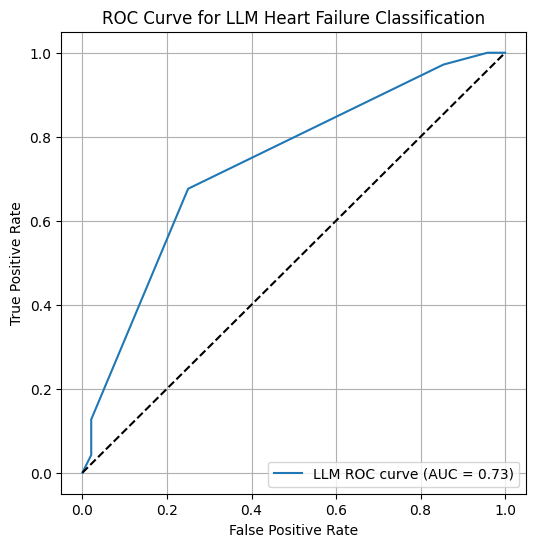

In [80]:
#time performance: manually labelled 3 min/note; llm 22-30s/note
df_perform=pd.read_csv("csv_with_llm_results.csv")
df_perform = df.dropna(subset=["confidence_llm"])
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_true = df_perform["is HF? (1,0: 1 for yes, 0 for no)"]
y_score = df_perform["confidence_llm"]
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"LLM ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for LLM Heart Failure Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


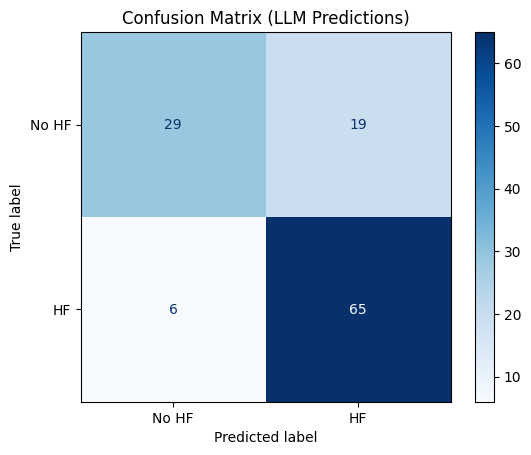

In [81]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = df_perform["has_heart_failure_llm"]
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["No HF", "HF"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (LLM Predictions)")
plt.show()


# HF with Agent

In [225]:
import os
from typing import Literal, TypedDict, List, Dict, Annotated
from langchain_core.runnables import RunnableConfig

from langgraph.graph import StateGraph, END
import operator
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from langgraph.types import Command, interrupt

In [237]:
class State(TypedDict):
    text: str
    classification_1: int
    classification_2: int
    classification_3: int
    final_classification: int
    entities: List[str]
    tokens: Annotated[List[Dict[str, Dict[str, int]]], operator.add]
    has_hf: str



In [238]:
def classification_node_1(state: State, config: RunnableConfig):
    '''Classify the patients into has target disease or not from the clinical note texts'''
    node_name = config["metadata"]["langgraph_node"]
    print(f"Executing node: {node_name}")

    prompt = PromptTemplate(
        input_variables=["text"],
        template="Classify the following clinical notes of a patient into one of the categories: has heart failure(1) or not(0).Output only 1 or 0. \n\nText:{text}\n\nCategory:", #
    )
    prompt_text = prompt.format(text=state["text"])
    response = model.generate_content([prompt_text])
    classification = int(response.text.strip())
    token_count = model.count_tokens(prompt_text).total_tokens
    tokens=[{node_name: {"total_tokens": token_count}}]
    return {"classification_1": classification, "tokens":tokens}

In [239]:
def classification_2_node(state: State, config: RunnableConfig):
    '''Classify the patients into has target disease or not from the clinical note texts'''
    node_name = config["metadata"]["langgraph_node"]
    print(f"Executing node: {node_name}")

    prompt = PromptTemplate(
        input_variables=["text"],
        template="Classify the following clinical notes of a patient into one of the categories: has heart failure(1) or not(0).The classification will not consider history heart failure.Output only 1 or 0. \n\nText:{text}\n\nCategory:", #
    )
    prompt_text = prompt.format(text=state["text"])
    response = model.generate_content([prompt_text])
    classification = int(response.text.strip())
    token_count = model.count_tokens(prompt_text).total_tokens
    tokens=[{node_name: {"total_tokens": token_count}}]
    return {"classification_2": classification, "tokens":tokens}

In [240]:
def decide_third(state: State) -> str:
    """To see if the third agent is needed"""
    c1 = state.get("classification_1")
    c2 = state.get("classification_2")

    if c1 is None or c2 is None:
        return "agree"

    if c1 == c2:
        return "agree"
    else:
        return "disagree"

In [241]:
def classification_3_node(state: State, config: RunnableConfig):
    '''Classify the patients into has target disease or not from the clinical note texts'''
    node_name = config["metadata"]["langgraph_node"]
    print(f"Executing node: {node_name}")

    prompt = PromptTemplate(
        input_variables=["text"],
        template="Determine if the following clinical notes of a patient has heart failure(1) or not(0).Positive result(1) is defined as the patient has ongoing heart failure or heart failure will affect the current treatment.Output only 1 or 0. \n\nText:{text}\n\nCategory:", #
    )
    prompt_text = prompt.format(text=state["text"])
    response = model.generate_content([prompt_text])
    classification = int(response.text.strip())
    token_count = model.count_tokens(prompt_text).total_tokens
    tokens=[{node_name: {"total_tokens": token_count}}]
    return {"classification_3": classification, "tokens":tokens}

In [242]:
def vote_node(state: State, config: RunnableConfig):
    node_name = config["metadata"]["langgraph_node"]
    print(f"Executing node: {node_name}")

    c1 = state.get("classification_1")
    c2 = state.get("classification_2")
    c3 = state.get("classification_3")

    votes = [c for c in (c1, c2, c3) if c is not None]

    # vote
    if not votes:
        final = None
    else:
        ones = sum(votes)
        zeros = len(votes) - ones
        final = 1 if ones >= zeros else 0

    tokens = [{node_name: {"total_tokens": 0}}]

    return {
        "final_classification": final,
        "tokens": tokens,
    }


In [243]:
def entity_extraction_node(state: State, config: RunnableConfig):
    '''Extract all the entities, related to HF,  from the text'''
    node_name = config["metadata"]["langgraph_node"]
    print(f"Executing node: {node_name}")

    prompt = PromptTemplate(
        input_variables=["text"],
        template="Extract all the entities (HFrEF, HFpEF, HFmrEF, ejection fraction, ejection fraction value) from the following clinical notes. Provide the result as a comma-separated list.\n\nText:{text}\n\nEntities:"
, #

    )
    prompt_text = prompt.format(text=state["text"])
    response = model.generate_content([prompt_text])
    entities = response.text.strip().split(", ")
    token_count = model.count_tokens(prompt_text).total_tokens
    tokens=[{node_name: {"total_tokens": token_count}}]

    return {"entities": entities, "tokens":tokens}

In [244]:
def find_keywords_node(state: State, config: RunnableConfig):
    '''Find if the keywords related to HF exsits'''
    node_name = config["metadata"]["langgraph_node"]
    print(f"Executing node: {node_name}")
    hf_keywords = [
        "heart failure",
        "HF",
        "reduced ejection fraction",
        "preserved ejection fraction",
        "HFrEF",
        "HFpEF",
        "BNP",
        "NT-proBNP"]
    text = state.get("text", "").lower()
    contains_hf = any(keyword.lower() in text for keyword in hf_keywords)
    tokens = [{node_name: {"total_tokens": len(text.split())}}]
    return {
        "has_hf": contains_hf,
        "tokens": tokens
    }


In [245]:
workflow = StateGraph(State)

workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction", entity_extraction_node)
workflow.add_node("find_keywords", find_keywords_node)

workflow.add_node("classification_2", classification_2_node)
workflow.add_node("classification_3", classification_3_node)
workflow.add_node("vote_node", vote_node)

workflow.set_entry_point("classification_node")

workflow.add_edge("classification_node", "entity_extraction")
workflow.add_edge("entity_extraction", "find_keywords")
workflow.add_edge("find_keywords", "classification_2")

# check if
workflow.add_conditional_edges(
    "classification_2",
    decide_third,
    {
        "agree": "vote_node",         # agree
        "disagree": "classification_3",  # don't agree
    },
)

# vote node
workflow.add_edge("classification_3", "vote_node")

# vote
workflow.add_edge("vote_node", END)

app = workflow.compile()


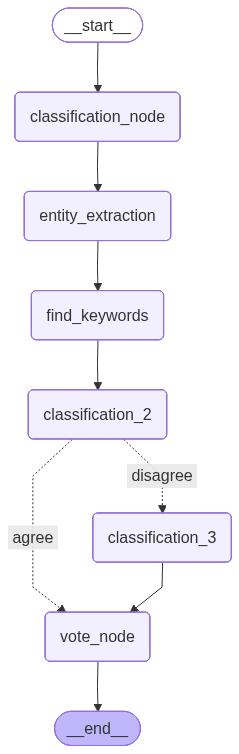

In [246]:
# Display a visualization of our graph
try:
    display(
        Image(
            app.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.API,
            )
        )
    )
except Exception as e:
    print(f"Error generating visualization: {e}")
    print("The graph structure is: classification_node -> entity_extraction -> summarization -> END")

In [247]:
#test case
start = time.time()
state_input = {"text": text[1]}
result = app.invoke(state_input)
end = time.time()
print(end - start)
# 3s per loop

Executing node: classification_node
Executing node: entity_extraction
Executing node: find_keywords
Executing node: classification_2
Executing node: vote_node
2.6384518146514893


In [260]:
print("Final Classification:", result["final_classification"])
print("\nEntities:", result["entities"][0])
print("\nTokens:", result["tokens"])
print(result)
print("\nHas HF Keywords:", result["has_hf"])
print('Total tokens used:', sum([list(x.values())[0]['total_tokens'] for x in result["tokens"]]))

Final Classification: 0

Entities: HFrEF

Tokens: [{'classification_node': {'total_tokens': 32}}, {'entity_extraction': {'total_tokens': 46}}, {'find_keywords': {'total_tokens': 1}}, {'classification_2': {'total_tokens': 50}}, {'vote_node': {'total_tokens': 0}}]
{'text': '_', 'classification_2': 0, 'final_classification': 0, 'entities': ['HFrEF', 'HFpEF', 'HFmrEF', 'ejection fraction', 'ejection fraction value'], 'tokens': [{'classification_node': {'total_tokens': 32}}, {'entity_extraction': {'total_tokens': 46}}, {'find_keywords': {'total_tokens': 1}}, {'classification_2': {'total_tokens': 50}}, {'vote_node': {'total_tokens': 0}}], 'has_hf': False}

Has HF Keywords: False
Total tokens used: 129


In [321]:
result_agent=[]
result_token_agent=[]
for i in range(115,120):
  state_input = {"text": texts[i]}
  result = app.invoke(state_input)
  result_agent.append(result["final_classification"])
  result_token_agent.append(sum([list(x.values())[0]['total_tokens'] for x in result["tokens"]]))


Executing node: classification_node
Executing node: entity_extraction
Executing node: find_keywords
Executing node: classification_2
Executing node: vote_node
Executing node: classification_node
Executing node: entity_extraction
Executing node: find_keywords
Executing node: classification_2
Executing node: vote_node
Executing node: classification_node
Executing node: entity_extraction
Executing node: find_keywords
Executing node: classification_2
Executing node: vote_node
Executing node: classification_node
Executing node: entity_extraction
Executing node: find_keywords
Executing node: classification_2
Executing node: vote_node
Executing node: classification_node
Executing node: entity_extraction
Executing node: find_keywords
Executing node: classification_2
Executing node: vote_node


In [274]:

#result_agent_accumulated=result_agent
#print(len(result_agent_accumulated))
#print(result_agent)
#result_token_acc=result_token_agent
#print(result_token_acc)

[20492, 10615, 15795, 13890, 15722]


In [322]:
#result_agent_accumulated.extend(result_agent)
#print(len(result_agent_accumulated))
#result_token_acc.extend(result_token_agent)
#print(len(result_token_acc))

120
120


In [324]:
#df["agent_prediction"] = result_agent_accumulated
#df["token_used"] = result_token_acc

#df.to_csv("llm_and_agent_results.csv", index=False)

# Agent Performance

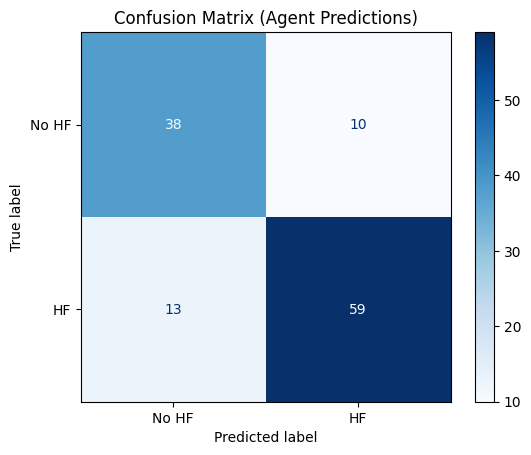

In [331]:
df_agent = pd.read_csv("llm_and_agent_results.csv")
df_agent = df.dropna(subset=["agent_prediction"])
y_pred = df_agent["agent_prediction"]
y_true = df_agent["is HF? (1,0: 1 for yes, 0 for no)"]
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["No HF", "HF"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Agent Predictions)")
plt.show()

# Baseline

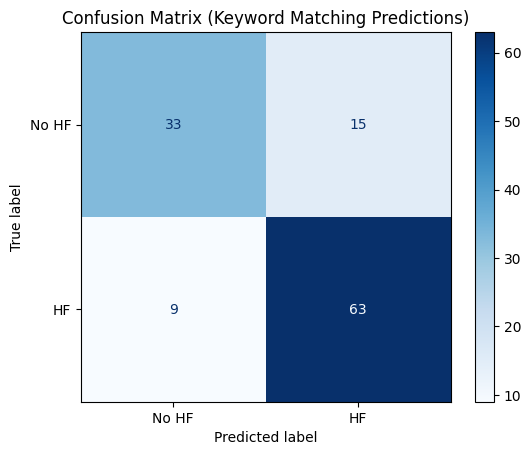

In [330]:
#keywords matching
result_baseline=[]
for text in texts:
  if "heart failure" in text.lower():
    result_baseline.append(1)
  else:
    result_baseline.append(0)

#print(result_baseline)
y_pred = result_baseline
y_true = df_agent["is HF? (1,0: 1 for yes, 0 for no)"]
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["No HF", "HF"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Keyword Matching Predictions)")
plt.show()

In [329]:
!jupyter nbconvert --to html HF_finalProject.ipynb

[NbConvertApp] Converting notebook HF_finalProject.ipynb to html
/usr/local/share/jupyter/nbconvert/templates/base/display_priority.j2:32: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.colab-display-data+json']) is not able to be represented.
  {%- elif type == 'text/vnd.mermaid' -%}
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 554218 bytes to HF_finalProject.html
